# Echo State Network as a tunable frequency generator

This is a simplified implementation of Herbert Jaeger's task of learning a simple non-autonomous system, [a frequency generator controlled by an external signal](http://www.scholarpedia.org/article/Echo_state_network). Plots at the end.

[See the ESN implementation](https://github.com/cknd/pyESN).


In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pyESN import ESN


## Task

The network will learn to generate a wave signal whose frequency is determined by some slowly changing control input.

#### 1) Generate some sample data:


In [2]:
rng = np.random.RandomState(42)
def updown_generator(N,min_period,max_period,n_changepoints):
    changepoints = np.insert(np.sort(rng.randint(0,N,n_changepoints)),[0,n_changepoints],[0,N])
    const_intervals = list(zip(changepoints,np.roll(changepoints,-1)))[:-1]
    updown_control = np.ones((N,2))
    updown_output = np.zeros((N,1))
    up = True
    for (t0,t1) in const_intervals:
        if t0 != t1:
            ud_output = 1 / (t1-t0)
            if up:
                updown_control[t0:t1,0] = np.linspace(0,1,t1-t0)
                updown_output[t0:t1,0] = ud_output
            else:
                updown_control[t0:t1,0] = np.linspace(1,0,t1-t0)
                updown_output[t0:t1,0] = -ud_output
            up = not up
    return updown_control, updown_output
    


In [3]:

N = 15000 # signal length
min_period = 2
max_period = 10
n_changepoints = int(N/200)
updown_control, updown_output = updown_generator(N,min_period,max_period,n_changepoints)

traintest_cutoff = int(np.ceil(0.7*N))

train_ctrl,train_output = updown_control[:traintest_cutoff],updown_output[:traintest_cutoff]
test_ctrl, test_output  = updown_control[traintest_cutoff:],updown_output[traintest_cutoff:]

#### 2) Instantiate, train & test the network
Parameters are mostly the same as in Herbert Jaeger's original Matlab code. 

In [4]:
esn = ESN(n_inputs = 2,
          n_outputs = 1,
          n_reservoir = 200,
          spectral_radius = 0.02,
          sparsity = 0.3,
          noise = 0.001,
          input_shift = [-.5,-.5],
          input_scaling = [2, 2],
          teacher_scaling = .2,
          teacher_shift = 0,
          out_activation = np.tanh,
          inverse_out_activation = np.arctanh,
          random_state = rng,
          silent = False)

pred_train = esn.fit(train_ctrl,train_output)

print("test error:")
pred_test = esn.predict(test_ctrl)
print(np.sqrt(np.mean((pred_test - test_output)**2)))

harvesting states...
fitting...
training error:
0.004213009487733606
test error:
0.0032955618210022382


#### 3) Plots
First, a look at the control signal, the target signal and the output of the model both during training and during testing.

Text(0.5, 1.0, 'test (excerpt)')

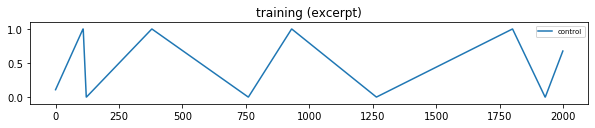

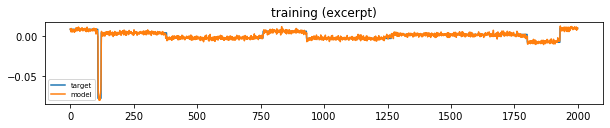

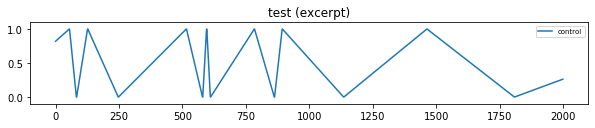

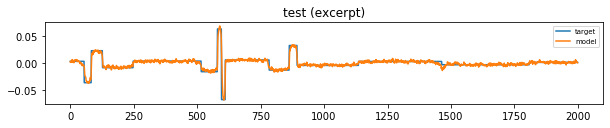

In [5]:
window_tr = range(int(len(train_output)/4),int(len(train_output)/4+2000))

plt.figure(figsize=(10,1.5))
plt.plot(train_ctrl[window_tr,0],label='control')
plt.legend(fontsize='x-small')
plt.ylim([-0.1,1.1])
plt.title('training (excerpt)')

plt.figure(figsize=(10,1.5))
plt.plot(train_output[window_tr],label='target')
plt.plot(pred_train[window_tr],label='model')
plt.legend(fontsize='x-small')
plt.title('training (excerpt)')

window_test = range(2000)
plt.figure(figsize=(10,1.5))
plt.plot(test_ctrl[window_test,0],label='control')
plt.legend(fontsize='x-small')
plt.ylim([-0.1,1.1])
plt.title('test (excerpt)')

plt.figure(figsize=(10,1.5))
plt.plot(test_output[window_test],label='target')
plt.plot(pred_test[window_test],label='model')
plt.legend(fontsize='x-small')
plt.title('test (excerpt)')